# DQN 
## Cartpole

Fabrice Mulotti

v2.1 -résolu en 500 cycles environ

In [1]:
import numpy as np
import gymnasium as gym
from collections import deque
import random

import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten , Input
from keras.optimizers import Adam # si vous utilisz un mac M1/M2, sinon le legacy n'est pas nécessaire
# from keras.optimizers import  Adam # si vous utilisz un mac, sinon le legacy n'est pas nécessaire

# from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# %matplotlib inline

2024-10-24 15:02:58.555347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 15:02:58.555687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 15:02:58.557591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 15:02:58.563009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 15:02:58.571677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

2.17.0


---
## Définition de l'environnement

In [2]:
ENV_NAME = 'CartPole-v1'

env = gym.make(ENV_NAME)
np.random.seed(100)
env.reset(seed=100)
nb_actions = env.action_space.n # Nombre d'action
nb_obs = env.observation_space.shape[0] # nombre de paramètre pour décrire l'environnement
print(f"Nombre d actions : {nb_actions}, Dimension de l env : {nb_obs}")

Nombre d actions : 2, Dimension de l env : 4


# Remarques sur l'environnement

2 actions possibles :<br>
    poussée vers la gauche<br>
    poussée vers la droite<br>
    
Observation :<br>
    Valeurs **continues** !

## Fonctions utiles

In [3]:
# Classe pour notre algorithme DQN
class DQN:
    def __init__(self, obs_size, action_size, gamma, learning_rate):
        # Objet : initialisation de la classe
        # Paramètres en entrée
        #     Nombre de paramètre pour décrire l'état
        #     Nombre d'actions
        #.    Paramètre gamma : dépréciation futur
        #     learning rate
        
        # dimension des états
        self.obs_size = obs_size
        
        # nombre d'actions
        self.action_size = action_size
        
        # gamma : dépréciation du futur
        self.gamma = gamma
        
        # learning rate
        self.learning_rate = learning_rate
        
        # autres paramètres
        self.update_freq = 100 # fréquence de copie des poids (1000)
        
        # autres structures
        self.replay_buffer = deque(maxlen=100000) # enregistrements des résultats
        
        # Modèle de réseaux de neurones
        self.main_network = self.build_model(16,8)
        self.target_network = self.build_model(16,8)
        # recopie des poids pour avoir des réseaux à l'identique
        self.target_network.set_weights(self.main_network.get_weights())
        
        self.debug = 0
        
    def build_model(self,layer1,layer2):
        # input : size of the 2 layers
        # output : model of neural network
        model = Sequential()
        model.add(Input(shape=(self.obs_size,)))
        model.add(Dense(layer1,activation='relu'))
        model.add(Dense(layer2,activation='relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate),jit_compile=True)
        return model

    def store_transition(self,state,action,reward,next_state,done):
        # input : 
        # output : nothing
        self.replay_buffer.append((state,action,reward,next_state,done))
      
    # @tf.function
    def mainPredict(self,state):
        actions = self.main_network.predict(state,verbose=0)
        return actions
        
    def policy(self, state, epsilon):
        # Policy : return action regarding the state according to the policy
        r = np.random.uniform()
        if r < epsilon:
            action = np.random.randint(self.action_size)
        else:
            actions=self.mainPredict(state)
            action = np.argmax(actions[0])
 
        return action
    
    # sous fonction entrainement graph
    @tf.function
    def _train_step(self, states, Q_values):    
            self.main_network.fit(states,Q_values,epochs=1,verbose=0)
            
    def debugP(self,message):
        if self.debug:
            print(message)
            
    def train_model(self,batch_size):
        self.debug=0
        # sélection d'un échantillon
        minibatch = random.sample(self.replay_buffer,batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))

        states=states.squeeze()
        next_states=next_states.squeeze()
        
        self.debugP(f"states shape {states.shape}")

        # On récupere les Q values des états rencontrés
        Q_values = self.main_network.predict(states,verbose = 0)
        self.debugP(f"Q_values shape {Q_values.shape}")
        
        Updates = rewards + self.gamma * np.amax(self.target_network.predict(next_states,verbose=0),axis=1) * (1-dones)
        self.debugP(f"Update {Updates.shape}")
        
        Q_values[ np.arange(len(Updates)),actions] = Updates
        
        self._train_step(states, Q_values)
        
    
    def update_weights(self):
        self.target_network.set_weights(self.main_network.get_weights())
        

In [4]:
# transformation des données pour compatabilité avec l'alimentation du réseau de neurones (1,s)`
def trans_state(s):
    return  np.reshape(s, [1, nb_obs])

In [9]:
num_episodes = 1000
batch_size = 16
gamma=0.99 

# variation du epsilon de notre politique e-greedy
epsilon_max=1.00
epsilon_min=0.10
epsilon_decay=0.992 

learning_rate=0.005

In [10]:
dqn = DQN(env.observation_space.shape[0],env.action_space.n,gamma,learning_rate)

In [11]:
print(f"Eager ? {tf.executing_eagerly()}")
tf.config.optimizer.set_jit(True)

Eager ? True


Episode:  0 ,Return 18.0 , epsilon  1.0 , end= False
Episode:  1 ,Return 16.0 , epsilon  0.99 , end= False
Episode:  2 ,Return 28.0 , epsilon  0.98 , end= False
Episode:  3 ,Return 18.0 , epsilon  0.98 , end= False
Episode:  4 ,Return 19.0 , epsilon  0.97 , end= False
Episode:  5 ,Return 16.0 , epsilon  0.96 , end= False
Episode:  6 ,Return 42.0 , epsilon  0.95 , end= False
Episode:  7 ,Return 10.0 , epsilon  0.95 , end= False
Episode:  8 ,Return 13.0 , epsilon  0.94 , end= False
Episode:  9 ,Return 23.0 , epsilon  0.93 , end= False
Episode:  10 ,Return 14.0 , epsilon  0.92 , end= False
Episode:  11 ,Return 33.0 , epsilon  0.92 , end= False
Episode:  12 ,Return 56.0 , epsilon  0.91 , end= False
Episode:  13 ,Return 11.0 , epsilon  0.9 , end= False
Episode:  14 ,Return 28.0 , epsilon  0.89 , end= False
Episode:  15 ,Return 21.0 , epsilon  0.89 , end= False
Episode:  16 ,Return 18.0 , epsilon  0.88 , end= False
Episode:  17 ,Return 19.0 , epsilon  0.87 , end= False
Episode:  18 ,Return 1

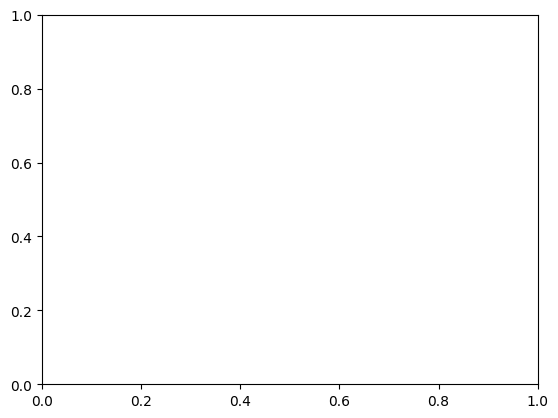

In [12]:
time_step = 0  # comptage du nombre total de mouvement
histoReturn=[] # pour graphique sur historique récompense
epsilon=epsilon_max
checkpoint_path="cartpole-save.weights.h5"

fig = plt.figure()
ax = fig.add_subplot(111)
goal450=0

for i in range(num_episodes):
    # somme de la récompense total pour une cycle
    Return = 0
    
    # reset env et conversion state
    state = trans_state(env.reset()[0])
    done=False
    truncated=False
    while not(done or truncated):
        
        # décommenter pour affichage
        # env.render()
    
        time_step += 1
        
        # copie des poids du réseau d'entrainement vers le réseau cible selon la fréquence choisie
        if time_step % dqn.update_freq == 0:
            dqn.update_weights()
        
        # sélection d'une action selon notre politique
        action = dqn.policy(state,epsilon)
        
        # jouer l'action
        next_state, reward, done, truncated , _ = env.step(action)
        next_state=trans_state(next_state) # reformatage
        if truncated:
            done=True 

        # enregistrement pour replay
        dqn.store_transition(state, action, reward, next_state, done)
        
        # et shift d'état
        state = next_state
        
        # cumul du retour G
        Return += reward

        # Done ?
        if done or truncated:
            # affichage du résultat du cyle
            print('Episode: ',i, ',' 'Return', Return,', epsilon ',np.round(epsilon,2),', end=',truncated)
            # ou
            # mise àa jour de notre graphique sur les gains tous les 10 cycles
            #if i % 10 == 0:
            #    ax.clear()
            #    ax.plot(histoReturn)
            #    display(fig)
            #    clear_output(wait=True)
    
            # on décremmente epsilon
            epsilon *= epsilon_decay
            epsilon = max(epsilon_min, epsilon)
            histoReturn.append(Return)
            # Sauvegarde des poids tous les 50 cycles
            if i % 50 == 0:
                dqn.main_network.save_weights(checkpoint_path)
            break

        # à partir de + batch-size on entraine le reseau
        if len(dqn.replay_buffer) > batch_size:
            dqn.train_model(batch_size)

    if Return > 450 :
        goal450 += 1
        if goal450==4:
            print("Objectif atteint :)")
            break
    else:
        goal450=0            

---
# Visualisons le résultat

In [9]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

In [22]:
ENV_NAME = 'CartPole-v1'

env_test = gym.make(ENV_NAME,render_mode="rgb_array")
env_test = RecordVideo(env, video_folder="video", name_prefix="eval",
                  episode_trigger=lambda x: True)
nb_actions = env_test.action_space.n # Nombre d'action
nb_obs = env_test.observation_space.shape[0] # nombre de paramètre pour décrire l'environnement


In [7]:
# optionnel  si vous démarrer sans exécuter les cellules prédédentes
dqn = DQN(env_test.observation_space.shape[0],env_test.action_space.n,0.0,0.0)
dqn.main_network.load_weights("cartpole-save.weights.h5")

/home/jupiter2/data/venv/rl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
state=trans_state(env_test.reset()[0])
done = False
truncated=False
Gain=0
while not (done or truncated):
    action = dqn.policy(state,0)
    next_state, reward, done, truncated , _ = env_test.step(action)
    Gain += reward
    state=trans_state(next_state)
print(f"Gain {Gain}")

Gain 128.0


In [24]:
env_test.close()

------
Labo

Décomposons notre entrainement

In [ ]:
minibatch = random.sample(dqn.replay_buffer,batch_size)
states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))

In [ ]:
states=states.squeeze()
next_states=next_states.squeeze()

In [ ]:
type(states)

In [ ]:
Q_values = dqn.main_network.predict(states,verbose = 0)

In [ ]:
Q_values

In [ ]:
dones

In [ ]:
dqn.target_network.predict(next_states,verbose=0)

In [ ]:
rewards

In [ ]:
np.amax(dqn.target_network.predict(next_states,verbose=0),axis=1)

In [ ]:
Updates = rewards + dqn.gamma * np.amax(dqn.target_network.predict(next_states,verbose=0),axis=1) * (1-dones)

In [ ]:
Updates

In [ ]:
Updates

In [ ]:
Q_values_C =Q_values.copy()

In [ ]:
Q_values_C[ np.arange(10),actions] = Updates

In [ ]:
Q_values_C